# EDA: Covid-19 statistics in United States from 22-01-2020 till 27-07-2020 

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas

In [2]:
covid19_df = pd.read_csv('./Dataset/archive/usa_county_wise.csv')
covid19_df['County'] = covid19_df['Combined_Key'].apply(lambda x: x.split(',')[0])
covid19_df['Date'] = pd.to_datetime(covid19_df['Date'], format='%m/%d/%y')
covid19_df.drop(columns=['Combined_Key', 'iso2', 'iso3', 'code3', 'FIPS', 'Admin2', 'Country_Region'], axis=1, inplace=True)
covid19_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 627920 entries, 0 to 627919
Data columns (total 8 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   UID             627920 non-null  int64         
 1   Province_State  627920 non-null  object        
 2   Lat             627920 non-null  float64       
 3   Long_           627920 non-null  float64       
 4   Date            627920 non-null  datetime64[ns]
 5   Confirmed       627920 non-null  int64         
 6   Deaths          627920 non-null  int64         
 7   County          627920 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(3), object(2)
memory usage: 38.3+ MB


In [3]:
covid19_df.head(10)

,UID,Province_State,Lat,Long_,Date,Confirmed,Deaths,County
0,16,American Samoa,-14.271000,-170.132000,2020-01-22,0,0,American Samoa
1,316,Guam,13.444300,144.793700,2020-01-22,0,0,Guam
2,580,Northern Mariana Islands,15.097900,145.673900,2020-01-22,0,0,Northern Mariana Islands
3,63072001,Puerto Rico,18.180117,-66.754367,2020-01-22,0,0,Adjuntas
4,63072003,Puerto Rico,18.360255,-67.175131,2020-01-22,0,0,Aguada
5,63072005,Puerto Rico,18.459681,-67.120815,2020-01-22,0,0,Aguadilla
6,63072007,Puerto Rico,18.251619,-66.126806,2020-01-22,0,0,Aguas Buenas
7,63072009,Puerto Rico,18.131361,-66.264131,2020-01-22,0,0,Aibonito
8,63072011,Puerto Rico,18.287985,-67.120611,2020-01-22,0,0,Anasco
9,63072013,Puerto Rico,18.406631,-66.675077,2020-01-22,0,0,Arecibo


## CoronaEDA class (The analyzer)

In [24]:
class CoronaEDA:
    def __init__(self, data):
        self.data = data
        states = geopandas.read_file('USA_States/USA_States.shp')
        self.states = states
        
    def confirmedDeathByState(self):
        return self.data.groupby('Province_State', as_index=False)[['Confirmed', 'Deaths']].sum().sort_values(by='Deaths', ascending=False)
    
    def deathRateByState(self):
        covid19_states_cd = self.confirmedDeathByState()
        covid19_states_cd['Death_Rate'] = 100*covid19_states_cd['Deaths']/covid19_states_cd['Confirmed']
        return covid19_states_cd.drop(['Deaths', 'Confirmed'], axis=1).sort_values(by='Death_Rate', ascending=False)
    
    def plotDeathMap(self):
        covid19_states_cd = self.confirmedDeathByState()
        states = self.states.copy()
        states['DEATHS'] = states['STATE_NAME'].map(lambda x: list(covid19_states_cd[covid19_states_cd['Province_State']==x]['Deaths'])[0])
        states.plot(column='DEATHS',cmap='Reds', legend=True, figsize=(15,10))
        plt.title('Death Cases')
        
    def plotConfirmedMap(self):
        covid19_states_cd = self.confirmedDeathByState()
        states = self.states.copy()
        states['CONFIRMED'] = states['STATE_NAME'].map(lambda x: list(covid19_states_cd[covid19_states_cd['Province_State']==x]['Confirmed'])[0])
        states.plot(column='CONFIRMED',cmap='Oranges', legend=True, figsize=(15,10))
        plt.title('Confirmed Cases')
    
    def plotDeathRateMap(self):
        covid19_states_deathrate = self.deathRateByState()
        states = self.states.copy()
        states['DEATH_RATE'] = states['STATE_NAME'].map(lambda x: list(covid19_states_deathrate[covid19_states_deathrate['Province_State']==x]['Death_Rate'])[0])
        states.plot(column='DEATH_RATE',cmap='jet', legend=True, figsize=(15,10))
        plt.title('Death Rate')
        
    
analyzer = CoronaEDA(covid19_df)        

## Confirmed & Death  Cases (Sorted by the number of Death cases)

In [7]:
analyzer.confirmedDeathByState().style.background_gradient(cmap='YlOrRd')

,Province_State,Confirmed,Deaths
36,New York,39808447,3176945
34,New Jersey,16506714,1221339
25,Massachusetts,9874030,666157
26,Michigan,6690544,576093
17,Illinois,11900637,541672
43,Pennsylvania,8096993,537261
5,California,17618695,481757
7,Connecticut,4239220,374346
11,Florida,12657802,292541
22,Louisiana,5383429,285084


## Death Rate
Death_Rate: number of deaths divided by number of confirmed cases

In [16]:
covid19_states_deathrate = analyzer.deathRateByState()
covid19_states_deathrate.head(5)

,Province_State,Death_Rate
47,South Dakota,14.383217
7,Connecticut,8.830540
26,Michigan,8.610555
39,Northern Mariana Islands,8.391098
36,New York,7.980580


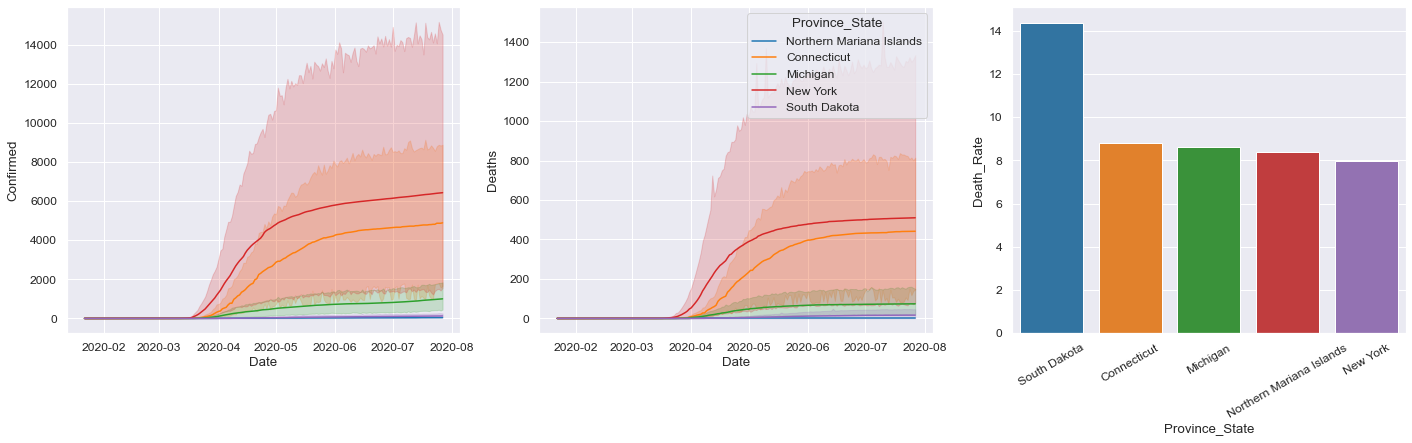

In [17]:

sns.set_style('darkgrid')
sns.set_context('notebook', font_scale=1.1)
ax = plt.figure(figsize=(24,6)).subplots(1,3)
most_affected = covid19_states_deathrate.head(5)['Province_State']

sns.lineplot(data=covid19_df[covid19_df['Province_State'].isin(most_affected)], x='Date', y='Confirmed', hue='Province_State', ax=ax[0], legend=False)
sns.lineplot(data=covid19_df[covid19_df['Province_State'].isin(most_affected)], x='Date', y='Deaths', hue='Province_State', ax=ax[1])
sns.barplot(data=covid19_states_deathrate[covid19_states_deathrate['Province_State'].isin(most_affected)], x='Province_State', y='Death_Rate', ax=ax[2])

ax[2].set_xticklabels(ax[2].get_xticklabels(), rotation=30)

plt.show()

c:\Dev\Python\lib\site-packages\geopandas\plotting.py:51: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:


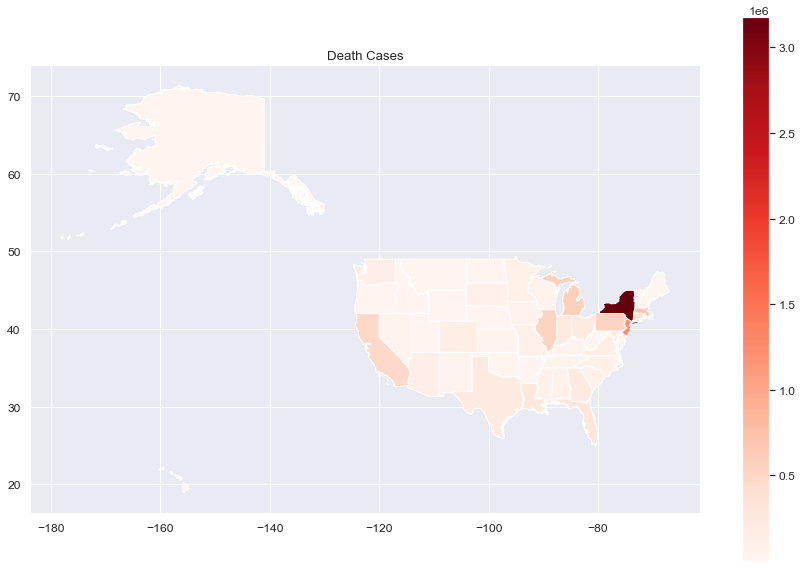

In [21]:
analyzer.plotDeathMap()

c:\Dev\Python\lib\site-packages\geopandas\plotting.py:51: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:


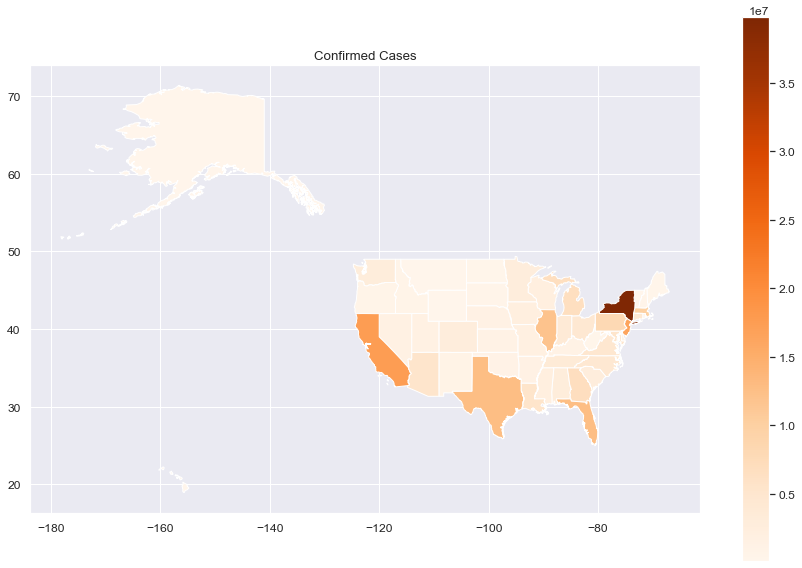

In [26]:
analyzer.plotConfirmedMap()

c:\Dev\Python\lib\site-packages\geopandas\plotting.py:51: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:


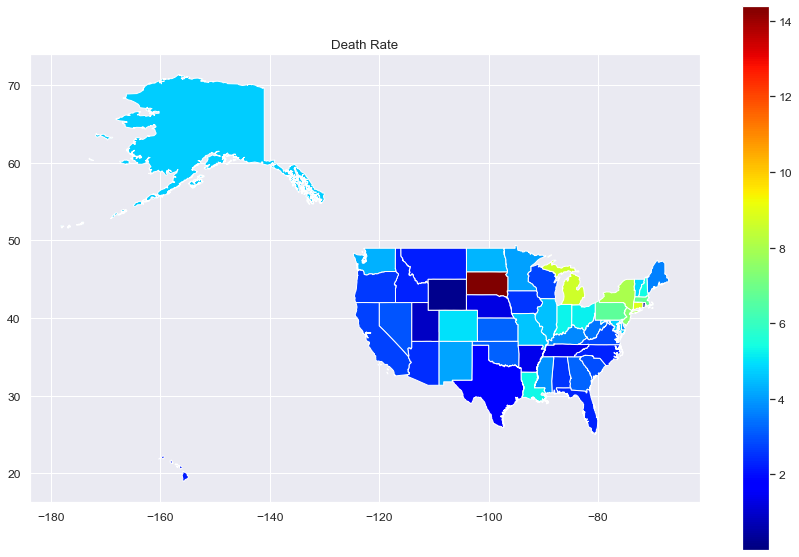

In [25]:
analyzer.plotDeathRateMap()